# mDPP

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

from omegaconf import DictConfig

import torch
from torch.utils.data import DataLoader
import lightning as L

from rl4co.envs import DPPEnv, MDPPEnv
from rl4co.data.dataset import tensordict_collate_fn, TensorDictDataset
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.tasks.rl4co import RL4COLitModule
from rl4co.models.rl.reinforce.baselines import CriticBaseline, RolloutBaseline, WarmupBaseline
from rl4co.models.rl.reinforce.critic import CriticNetwork

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


## mDPP Environment

We declare the environment here. This will automatically download the data 

In [2]:
env = MDPPEnv() # TODO: load datasets

td = env.reset(batch_size=[2])
print(td)

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([2, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        done: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        i: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        keepout: Tensor(shape=torch.Size([2, 100]), device=cpu, dtype=torch.bool, is_shared=False),
        locs: Tensor(shape=torch.Size([2, 100, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        probe: Tensor(shape=torch.Size([2, 100]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([2]),
    device=cpu,
    is_shared=False)


/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
bs = 10

td = env.reset(batch_size=[bs])
td_init = td.clone()

actions = []
probes = td['probe'].clone()
keepouts = td['action_mask'].clone() # this includes also the probes + decaps placed later

def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td

for i in range(20):
    # pick random action from action_mask
    td = random_policy(td)
    actions.append(td['action'])
    td = env.step(td)['next']

actions_ = torch.stack(actions, dim=1)

/home/botu/Dev/rl4co/notebooks/dpp/../../rl4co/envs/mdpp.py:294: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle((0, 0), 1, 1, color=c, edgecolor="k", linestyle="-", linewidth=1)


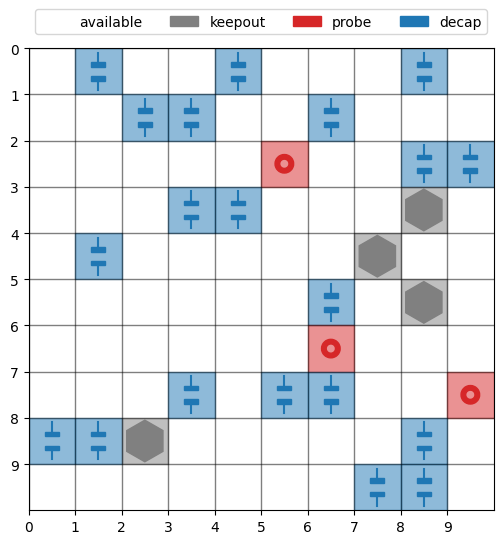

In [4]:
env.render(td[0], actions_[0])

## Attention Model

In [5]:
# Load environment with test data

# env = DPPEnv()

env = MDPPEnv() # TODO: load datasets
env.max_decaps = 20

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=tensordict_collate_fn,
)

policy = AttentionModelPolicy(
    env,
)

# model = torch.compile(model)

td = next(iter(dataloader))
td = env.reset(td)

out = policy(td, decode_type="sampling")

print(out)

{'reward': tensor([10.7650,  8.7715,  8.7884,  7.9849,  9.1390,  7.3628,  7.7026,  7.4368,
         9.7000,  8.4545,  8.9901,  9.0328,  9.3554,  9.6896,  8.9993, 10.5004,
         8.4648, 10.1616,  8.4094,  9.7256,  7.5575,  8.3335,  9.4974,  6.7246,
         8.6903,  8.8174,  9.0379,  8.2320,  7.3746, 10.5716, 10.0995,  7.2075,
         8.7264,  9.2535,  8.9131,  8.3266,  8.1483,  8.5171,  8.1348, 10.3058,
         9.5947,  9.5299,  9.2332, 10.4819,  7.7774, 10.4888, 11.0906, 10.3146,
         9.8196,  7.3247,  8.3762,  7.9089,  9.6498,  9.6670, 10.3533,  8.9274,
        10.4782,  9.3131,  6.4445,  9.1689,  9.2848,  8.9953,  9.2767,  9.9693]), 'log_likelihood': tensor([-86.5707, -69.7443, -77.9802, -76.1851, -87.8273, -80.2105, -78.6125,
        -77.7938, -85.2794, -83.8551, -82.0410, -82.5042, -84.4569, -87.6455,
        -77.4790, -78.1854, -86.7478, -89.1806, -76.2766, -82.8048, -87.1786,
        -85.1990, -69.3378, -84.1002, -83.4313, -83.4073, -86.8454, -82.6857,
        -74.4693,

In [6]:
baseline = CriticBaseline(CriticNetwork(env))
# baseline = (WarmupBaseline(RolloutBaseline()))

model = AttentionModel(
    env,
    policy,
    baseline,
)


td = next(iter(dataloader))

td = env.reset(td)
init_td = td.clone()


out = model(td, decode_type="sampling")

print(out)

{'reward': tensor([ 8.9948,  8.8315,  7.8402,  9.1429,  8.8342,  8.4022,  8.1765,  7.5990,
        10.7198,  8.7785,  9.6992,  7.9084,  9.1815,  8.5870,  8.5931, 10.1877,
         9.3662,  9.9054,  9.4025,  8.9307,  9.1736,  8.8160,  9.4150,  7.4366,
         8.4758,  9.4036,  9.6847,  9.0543,  8.3317, 10.2734,  9.1970,  7.6418,
         8.8865,  7.4342,  8.8743,  7.5782,  8.3650,  8.6644,  9.3947,  8.6579,
        11.4112,  9.1580, 10.1951,  8.8244,  9.5086,  8.3298,  9.4517,  4.6646,
        10.2183,  8.4884, 10.0121,  9.0521,  7.7609,  7.7660,  9.8062, 10.0212,
         9.0641, 10.1350,  8.0237,  9.2700,  9.2573,  9.4513,  9.0255, 10.8522]), 'log_likelihood': tensor([-87.1911, -69.8598, -73.5484, -75.4520, -86.9227, -82.0553, -77.8688,
        -78.2096, -90.1075, -85.1803, -83.3392, -82.5877, -83.4271, -88.3788,
        -75.1698, -82.0366, -82.7541, -88.9221, -77.2968, -83.2987, -88.0215,
        -82.3533, -73.2223, -87.8280, -79.8439, -82.5311, -86.2820, -83.3538,
        -80.8028,

/home/botu/Dev/rl4co/notebooks/dpp/../../rl4co/models/rl/reinforce/baselines.py:121: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return v.detach(), -F.mse_loss(v, c.detach())


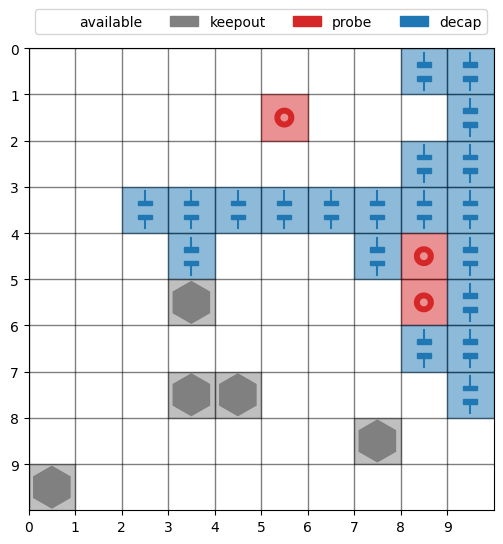

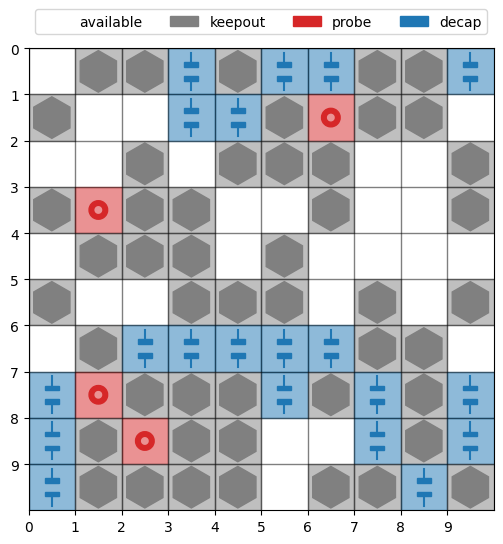

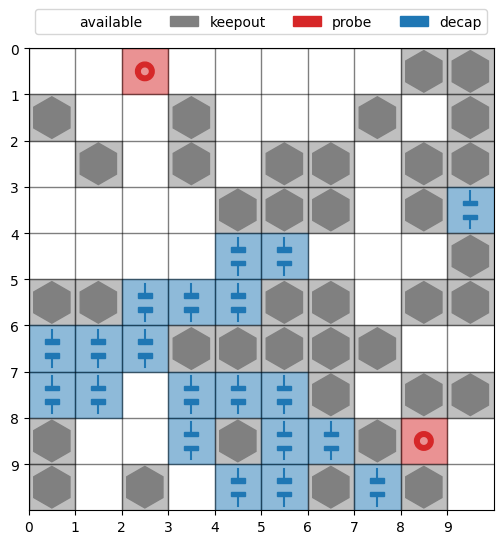

In [7]:
## Plot

probes = td['probe'].clone().cpu()
keepouts = td['action_mask'].clone().cpu()

out = policy(init_td.clone(), decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(3):
    env.render(init_td[i], decaps[i])


# Main setup

In [8]:
config = DictConfig(
    {"data": {
            "train_size": 1000, # with 1 epochs, this is 1k samples
            "val_size": 100, 
            "test_size": 100,
            "batch_size": 64,
    },
    "optimizer": {
        "lr": 1e-4,
        "weight_decay": 1e-6,
    }})

# Recreate model (so CUDA is initialized in the model)

model = AttentionModel(env)

lit_module = RL4COLitModule(cfg=config, env=env, model=model)

In [9]:
# Trainer
trainer = L.Trainer(
    max_epochs=3, # only few epochs
    accelerator="gpu", # use GPU if available, else you can use others as "cpu"
    devices=[0], # GPU number, or multiple GPUs [0, 1, 2, ...]
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle faster training with mixed precision
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
No optimizer specified, using default

  | Name  | Type           | Params
-----------------------------------------
0 | env   | MDPPEnv        | 0     
1 | model | AttentionModel | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total pa

Sanity Checking: 0it [00:00, ?it/s]

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Train

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## Results

In [10]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")

batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy")
out['reward'].mean()

tensor(8.2128, device='cuda:0')

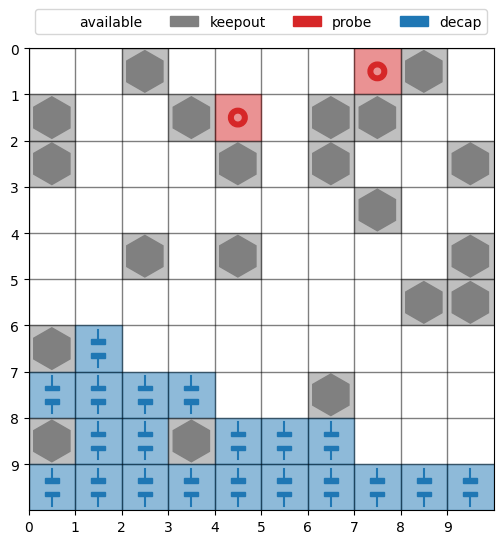

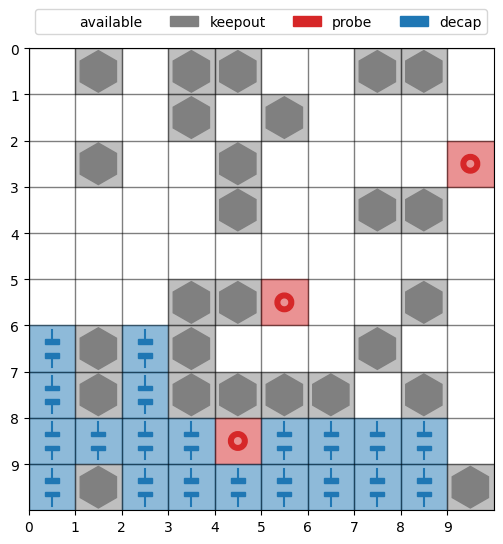

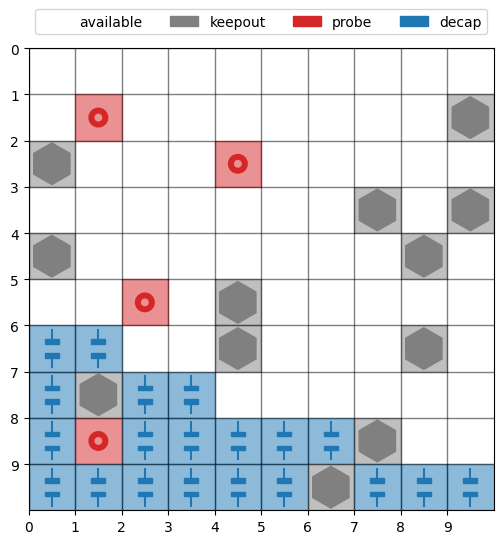

In [13]:
## Plot

init_td = env.reset(batch).to("cuda")
probes = init_td['probe'].clone().cpu()
keepouts = init_td['action_mask'].clone().cpu()

out = policy(init_td.clone(), decode_type="greedy", return_actions=True)
decaps = out['actions'].cpu()

for i in range(3):
    env.render(init_td[i], decaps[i])
